In [3]:
import jax
import healpy as hp
import numpy as np

from furax.comp_sep import spectral_cmb_variance, get_clusters, optimize

import jax.numpy as jnp

from furax._base.core import HomothetyOperator
from furax.landscapes import StokesPyTree
from furax.tree import allclose
from functools import partial
import matplotlib.pyplot as plt

In [5]:
GAL020 = np.load('masks/GAL_PlanckMasks_64.npz')['GAL020']
GAL040 = np.load('masks/GAL_PlanckMasks_64.npz')['GAL040']
GAL060 = np.load('masks/GAL_PlanckMasks_64.npz')['GAL060']

In [6]:
nside = 64
npixel = 12 * nside**2
stokes_type = 'QU'
frequency_count = 15
nu = jnp.linspace(40.0, 402.0, frequency_count)

In [7]:
comp_keys = jax.random.split(jax.random.PRNGKey(0), 3)
stokes_cls = StokesPyTree.class_for(stokes_type)

sky = {
    'cmb': stokes_cls.normal(comp_keys[0], (npixel,)),
    'dust': stokes_cls.normal(comp_keys[1], (npixel,)),
    'synchrotron': stokes_cls.normal(comp_keys[2], (npixel,)),
}

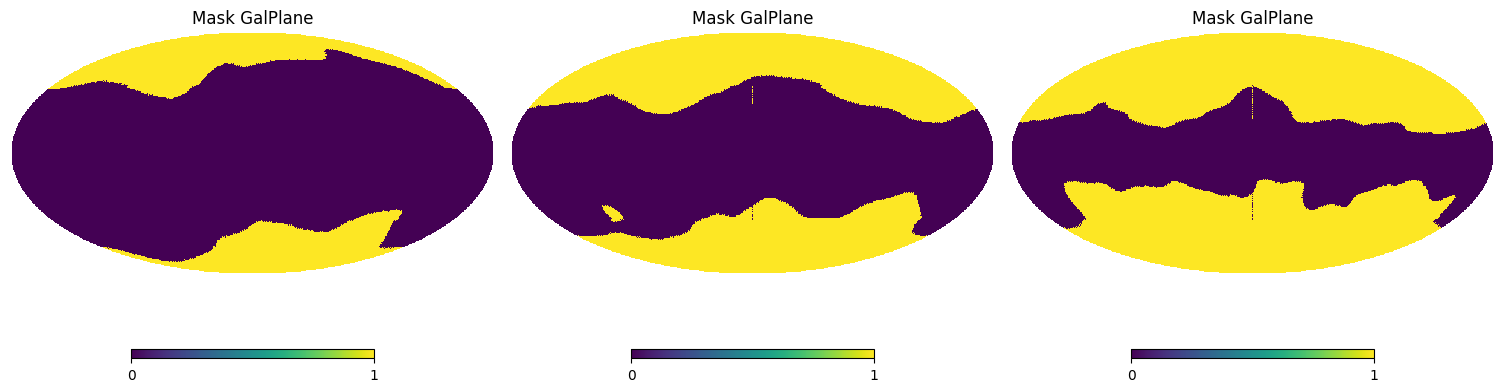

In [8]:
figure = plt.figure(figsize=(15, 15))
hp.mollview(GAL020, title='Mask GalPlane', sub=(1, 3, 1))
hp.mollview(GAL040, title='Mask GalPlane', sub=(1, 3, 2))
hp.mollview(GAL060, title='Mask GalPlane', sub=(1, 3, 3))
plt.show()

In [ ]:
temp_dust_patches_count = 10
beta_dust_patches_count = 20
beta_pl_patches_count = 5


temp_dust_patch_indices = get_clusters(GAL020, temp_dust_patches_count, jax.random.PRNGKey(0))
beta_dust_patch_indices = get_clusters(GAL020, beta_dust_patches_count, jax.random.PRNGKey(0))
beta_pl_patch_indices = get_clusters(GAL020, beta_pl_patches_count, jax.random.PRNGKey(0))

params = {
    'temp_dust': jnp.linspace(10.0, 30.0, temp_dust_patches_count),
    'beta_dust': jnp.linspace(1.5, 2.5, beta_dust_patches_count),
    'beta_pl': jnp.linspace(-3.0, -2.0, beta_pl_patches_count),
}

patch_indices = {
    'temp_dust_patches': temp_dust_patch_indices,
    'beta_dust_patches': beta_dust_patch_indices,
    'beta_pl_patches': beta_pl_patch_indices,
}

# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(temp_dust_patch_indices, title='Temperature Dust Patches', sub=(1, 3, 1))
hp.mollview(beta_dust_patch_indices, title='Beta Dust Patches', sub=(1, 3, 2))
hp.mollview(beta_pl_patch_indices, title='Beta PL Patches', sub=(1, 3, 3))

# Display the plot
plt.show()

TypeError: get_clusters() missing 1 required positional argument: 'key'

: 

In [7]:
@jax.jit
def get_cutout_from_mask(ful_map, indices):
    return jnp.take(ful_map, indices)


@jax.jit
def from_cutout_to_fullmap(goodpix, indices, ful_map):
    return ful_map.at[indices].set(goodpix)


(indices,) = jnp.where(GAL020 == 1)

masked_sky = jax.tree.map(lambda full_map: get_cutout_from_mask(full_map, indices), sky)
masked_clusters = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int32), patch_indices
)

In [12]:
from generate_maps import simulate_D_from_params

dust_nu0 = 150.0
synchrotron_nu0 = 20.0

spectral_cmb_variance = partial(
    spectral_cmb_variance, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0
)

stokes = 'QU'

d = simulate_D_from_params(
    params,
    masked_clusters,
    nu,
    masked_sky,
    stokes,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
)


N = HomothetyOperator(jnp.ones(1), _in_structure=d.structure)

wrong_params = jax.tree.map(
    lambda x: jax.random.normal(jax.random.PRNGKey(0), x.shape) * 0.2 + x, params
)

In [ ]:
good_var = spectral_cmb_variance(params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
bad_var = spectral_cmb_variance(wrong_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

print(f'Good variance : {good_var} , Bad variance : {bad_var}')
print(f'Good variance is better than bad variance : {good_var < bad_var}')

Good variance : 1.9697431244929993 , Bad variance : 2.392095392634851 
Good variance is better than bad variance : True


In [ ]:
import optax
import optax.tree_utils as otu

solver = optax.lbfgs()

final_params, final_state = optimize(
    params,
    spectral_cmb_variance,
    solver,
    max_iter=100,
    tol=1e-4,
    verbose=True,
    nu=nu,
    N=N,
    d=d,
    patch_indices=masked_clusters,
)


print(
    f"Final parameters: {final_params}, number of evaluations: {otu.tree_get(final_state, 'count')}"
)
last_value = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
print(f'Last Value: {last_value}')

update norm 67.23930779440374 at iter 0 value inf
update norm 0.05151629637842463 at iter 1 value 1.9697431244935113
update norm 0.020250837808770707 at iter 2 value 1.968409462962489
update norm 0.009603934200142475 at iter 3 value 1.9681772444960437
update norm 0.004522962907657648 at iter 4 value 1.9681387308947378
update norm 0.0035213772285755396 at iter 5 value 1.9681319458242648
update norm 0.012888645591436255 at iter 6 value 1.96812737759485
update norm 0.03187636815861763 at iter 7 value 1.9681141649416516
update norm 0.0856310806824494 at iter 8 value 1.9680858435915844
update norm 0.1506180039182451 at iter 9 value 1.9680226757810153
update norm 0.07385283229271254 at iter 10 value 1.9679541048651732
update norm 0.012398296963235356 at iter 11 value 1.9678850885762023
update norm 0.0036138414991945863 at iter 12 value 1.9678513713270744
update norm 0.0013230713358837061 at iter 13 value 1.967848450524694
update norm 0.0018770972367877367 at iter 14 value 1.9678477175670537


In [ ]:
diff = jax.tree.map(lambda x, y: jnp.abs(x - y), final_params, params)
print(f'Difference: {diff}')
print(f'All close: {allclose(final_params , params)}')

good_var = spectral_cmb_variance(params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
found_var = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

print(f'Good variance : {good_var} , Bad variance : {bad_var}')
print(f'Good variance is better than bad variance : {good_var < bad_var}')

Difference: {'beta_dust': Array([0.05940931, 0.00577722, 0.0126767 , 0.0132646 , 0.0013767 ,
       0.00356302, 0.02978986, 0.05180431, 0.00742601, 0.00425985,
       0.01149651, 0.01840743, 0.0075626 , 0.01625152, 0.02485424,
       0.00173486, 0.01846423, 0.00837022, 0.00993004, 0.00011424],      dtype=float64), 'beta_pl': Array([0.19354235, 0.03651082, 0.42859218, 0.48084183, 0.11913897],      dtype=float64), 'temp_dust': Array([0.28862031, 0.42973495, 0.5723486 , 0.245953  , 0.08225898,
       0.36403195, 1.02150834, 0.84957078, 0.04525634, 0.06763357],      dtype=float64)}
All close: False
Good variance : 1.9697431244929993 , Found variance : 1.9674153845353084 
Found variance is better than good variance : True


In [22]:
from furax import Config
import lineax as lx

wrong_params = jax.tree.map(
    lambda x: jax.random.normal(jax.random.PRNGKey(0), x.shape) * 0.2 + x, params
)

options = {'solver': lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000), 'solver_throw': False}

with Config(**options):
    final_params, final_state = optimize(
        wrong_params,
        spectral_cmb_variance,
        solver,
        max_iter=100,
        tol=1e-10,
        verbose=True,
        nu=nu,
        N=N,
        d=d,
        patch_indices=masked_clusters,
    )

In [ ]:
print(
    f"Final parameters: {final_params}, number of evaluations: {otu.tree_get(final_state, 'count')}"
)
last_value = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
print(f'Last Value: {last_value}')

diff = jax.tree.map(lambda x, y: jnp.abs(x - y), final_params, params)
print(f'Difference: {diff}')
print(f'All close: {allclose(final_params , params)}')

good_var = spectral_cmb_variance(params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
found_var = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

print(f'Good variance : {good_var} , Bad variance : {bad_var}')
print(f'Good variance is better than bad variance : {good_var < bad_var}')

Final parameters: {'beta_dust': Array([1.55965158, 1.54594906, 1.61617836, 1.64288306, 1.70723287,
       1.76471331, 1.8472794 , 1.9206438 , 1.91298391, 1.9669797 ,
       2.01576767, 2.06169267, 2.1394954 , 2.16912288, 2.26342329,
       2.28900693, 2.36210605, 2.38435116, 2.45890322, 2.49765325],      dtype=float64), 'beta_pl': Array([-3.22920854, -2.68138282, -2.94391598, -1.77461483, -1.88842524],      dtype=float64), 'temp_dust': Array([ 9.70942361, 12.67074412, 15.06091915, 16.98783317, 18.87662388,
       20.84742593, 22.22177504, 26.31661896, 27.8807676 , 30.1519619 ],      dtype=float64)}, number of evaluations: 100
Last Value: 1.9674152292453058
Difference: {'beta_dust': Array([0.05965158, 0.00668252, 0.01091521, 0.01501167, 0.00329344,
       0.00155541, 0.03148993, 0.05222275, 0.00806872, 0.00670451,
       0.01054812, 0.0172547 , 0.00791646, 0.01508764, 0.02658119,
       0.00046675, 0.02000079, 0.01038569, 0.0115348 , 0.00234675],      dtype=float64), 'beta_pl': Array([0

In [24]:
wrong_params = jax.tree.map(
    lambda x: jax.random.normal(jax.random.PRNGKey(0), x.shape) * 0.8 + x, params
)

options = {'solver': lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000), 'solver_throw': False}

with Config(**options):
    final_params, final_state = optimize(
        wrong_params,
        spectral_cmb_variance,
        solver,
        max_iter=50,
        tol=1e-10,
        verbose=True,
        nu=nu,
        N=N,
        d=d,
        patch_indices=masked_clusters,
    )

In [ ]:
print(
    f"Final parameters: {final_params}, number of evaluations: {otu.tree_get(final_state, 'count')}"
)
last_value = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
print(f'Last Value: {last_value}')


diff = jax.tree.map(lambda x, y: jnp.abs(x - y), final_params, params)
print(f'Difference: {diff}')
print(f'All close: {allclose(final_params , params)}')

good_var = spectral_cmb_variance(params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
found_var = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

print(f'Good variance : {good_var} , Bad variance : {bad_var}')
print(f'Good variance is better than bad variance : {good_var < bad_var}')

Final parameters: {'beta_dust': Array([1.56219501, 1.54797421, 1.6032405 , 1.63774592, 1.70313147,
       1.76122864, 1.84729369, 1.92362992, 1.91190687, 1.95901557,
       2.02040594, 2.06652841, 2.14061936, 2.17470678, 2.26424313,
       2.27867653, 2.36471371, 2.38444389, 2.45929723, 2.49385363],      dtype=float64), 'beta_pl': Array([-3.56219755, -2.67207862, -3.1397604 , -2.33997318, -2.07198975],      dtype=float64), 'temp_dust': Array([ 9.68965457, 12.71113221, 15.4340221 , 17.18911212, 18.78686149,
       20.97349772, 22.22890417, 25.89909751, 27.97742087, 31.22189766],      dtype=float64)}, number of evaluations: 50
Last Value: 1.9676227538685267
Difference: {'beta_dust': Array([0.06219501, 0.00465736, 0.00202265, 0.02014882, 0.00739485,
       0.00192926, 0.03150421, 0.05520887, 0.00914576, 0.01466864,
       0.00590985, 0.01241896, 0.00904041, 0.00950374, 0.02740102,
       0.01079715, 0.02260845, 0.01029295, 0.01192881, 0.00614637],      dtype=float64), 'beta_pl': Array([0.

In [28]:
import jaxopt

wrong_params = jax.tree.map(
    lambda x: jax.random.normal(jax.random.PRNGKey(0), x.shape) * 0.5 + x, params
)


options = {'solver': lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000), 'solver_throw': False}

with Config(**options):
    scipy_solver = jaxopt.ScipyMinimize(
        fun=spectral_cmb_variance, method='TNC', jit=True, tol=1e-10, maxiter=1000
    )
    result = scipy_solver.run(wrong_params, nu=nu, N=N, d=d, patch_indices=masked_clusters)
    result.params

/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jaxopt/_src/scipy_wrappers.py:343: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


In [ ]:
print(f'Final parameters: {result.params}, number of evaluations: {result.state.iter_num}')
last_value = spectral_cmb_variance(result.params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
print(f'Last Value: {last_value}')

diff = jax.tree.map(lambda x, y: jnp.abs(x - y), result.params, params)
print(f'Difference: {diff}')
print(f'All close: {allclose( result.params , params)}')

good_var = spectral_cmb_variance(params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
found_var = spectral_cmb_variance(result.params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

print(f'Good variance : {good_var} , Found variance : {found_var} ')
print(f'Found variance is better than good variance : {found_var < good_var}')

Final parameters: {'beta_dust': Array([1.54122098, 1.45819386, 1.66423758, 1.62275839, 1.72786714,
       1.74833724, 1.82335   , 1.9201992 , 1.90993046, 1.95738998,
       2.00264487, 2.04773854, 2.12074613, 2.16716361, 2.23877476,
       2.27747991, 2.34011838, 2.38577718, 2.4340529 , 2.496341  ],      dtype=float64), 'beta_pl': Array([-3.41841698, -2.79551208, -2.70174201, -2.74708858, -2.37779832],      dtype=float64), 'temp_dust': Array([ 9.879596  , 13.89312583, 14.01017005, 17.71485404, 18.50818273,
       20.97659514, 23.52126927, 27.26072875, 27.88490813, 30.9797512 ],      dtype=float64)}, number of evaluations: 28
Last Value: 1.9693476179965872
Difference: {'beta_dust': Array([0.04122098, 0.09443772, 0.05897442, 0.03513635, 0.01734082,
       0.01482065, 0.00756053, 0.05177814, 0.01112217, 0.01629423,
       0.02367092, 0.03120883, 0.01083282, 0.01704692, 0.00193266,
       0.01199377, 0.00198689, 0.00895967, 0.01331552, 0.003659  ],      dtype=float64), 'beta_pl': Array([0.

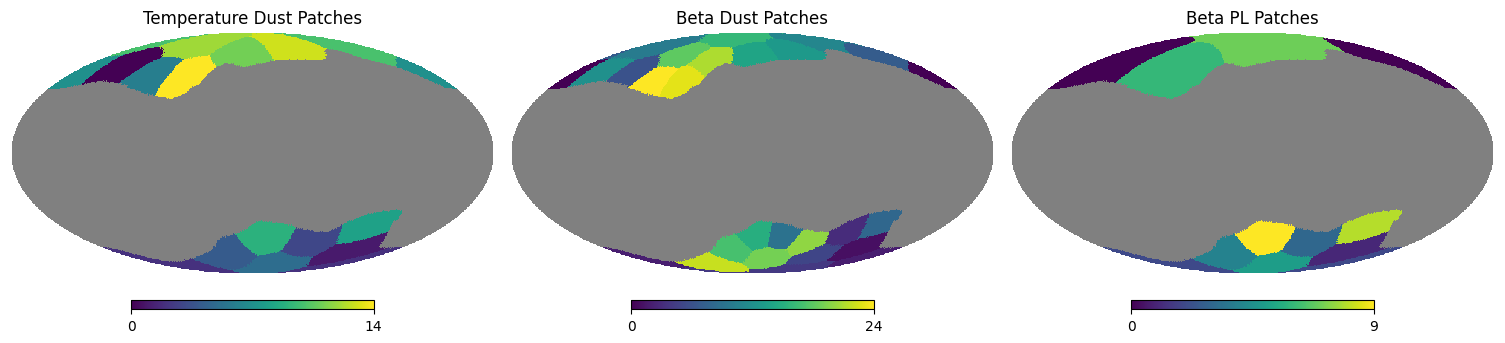

In [36]:
wrong_temp_dust_patches_count = 15
wrong_beta_dust_patches_count = 25
wrong_beta_pl_patches_count = 10


wrong_temp_dust_patch_indices = get_clusters(
    GAL020, wrong_temp_dust_patches_count, jax.random.PRNGKey(0)
)
wrong_beta_dust_patch_indices = get_clusters(
    GAL020, wrong_beta_dust_patches_count, jax.random.PRNGKey(0)
)
wrong_beta_pl_patch_indices = get_clusters(
    GAL020, wrong_beta_pl_patches_count, jax.random.PRNGKey(0)
)

wrong_patch_params = {
    'temp_dust': jnp.linspace(10.0, 30.0, wrong_temp_dust_patches_count),
    'beta_dust': jnp.linspace(1.5, 2.5, wrong_beta_dust_patches_count),
    'beta_pl': jnp.linspace(-3.0, -2.0, wrong_beta_pl_patches_count),
}

wrong_patch_indices = {
    'temp_dust_patches': temp_dust_patch_indices,
    'beta_dust_patches': beta_dust_patch_indices,
    'beta_pl_patches': beta_pl_patch_indices,
}

# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(wrong_temp_dust_patch_indices, title='Temperature Dust Patches', sub=(1, 3, 1))
hp.mollview(wrong_beta_dust_patch_indices, title='Beta Dust Patches', sub=(1, 3, 2))
hp.mollview(wrong_beta_pl_patch_indices, title='Beta PL Patches', sub=(1, 3, 3))

# Display the plot
plt.show()


(indices,) = jnp.where(GAL020 == 1)

masked_sky = jax.tree.map(lambda full_map: get_cutout_from_mask(full_map, indices), sky)
masked_wrong_clusters = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int32), wrong_patch_indices
)

In [37]:
options = {'solver': lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000), 'solver_throw': False}

with Config(**options):
    wrong_patch_final_params, wrong_patch_final_state = optimize(
        wrong_patch_params,
        spectral_cmb_variance,
        solver,
        max_iter=50,
        tol=1e-10,
        verbose=True,
        nu=nu,
        N=N,
        d=d,
        patch_indices=masked_wrong_clusters,
    )

update norm 82.08047291768935 at iter 0 value inf
update norm 1.0 at iter 1 value 2.508206737482858
update norm 0.16038065295820703 at iter 2 value 2.005241730745153
update norm 0.09180220111038975 at iter 3 value 1.9768074287184136
update norm 0.030237091680275063 at iter 4 value 1.9722093394643585
update norm 0.02255253823795978 at iter 5 value 1.9717319672157143
update norm 0.022977421456530013 at iter 6 value 1.971580899296396
update norm 0.08453763236289946 at iter 7 value 1.9714753452567662
update norm 0.1989705391291394 at iter 8 value 1.9711597061877715
update norm 0.4109233194769819 at iter 9 value 1.97052041537341
update norm 0.260857571617402 at iter 10 value 1.9694413724327686
update norm 0.16260222696498866 at iter 11 value 1.9688864297718012
update norm 0.05390908327840173 at iter 12 value 1.9681278211812758
update norm 0.012362592530718667 at iter 13 value 1.9679374726414463
update norm 0.003067377683306953 at iter 14 value 1.9679242155033103
update norm 0.00154536243300

In [ ]:
print(f'Final parameters: {wrong_patch_final_params}')
print(f"number of evaluations: {otu.tree_get(wrong_patch_final_state, 'count')}")

last_value = spectral_cmb_variance(
    wrong_patch_final_params, nu=nu, d=d, N=N, patch_indices=masked_wrong_clusters
)

print(f'Last Value: {last_value}')

good_var = spectral_cmb_variance(params, nu=nu, d=d, N=N, patch_indices=masked_clusters)
wrong_patch_found_var = spectral_cmb_variance(
    wrong_patch_final_params, nu=nu, d=d, N=N, patch_indices=masked_wrong_clusters
)
found_var = spectral_cmb_variance(final_params, nu=nu, d=d, N=N, patch_indices=masked_clusters)

print(f'Good variance : {good_var} , ')
print(f'Found variance : {found_var} ')
print(f'wrong patch variance : {wrong_patch_found_var}')
print(f'Found variance is better than good variance : {found_var < good_var}')
print(f'Wrong patches variance is better than good variance : {wrong_patch_found_var < good_var}')
print(f'Wrong patches is better than found variance : {wrong_patch_found_var < found_var}')

Final parameters: {'beta_dust': Array([1.65342739, 1.639047  , 1.71547782, 1.74102361, 1.80747816,
       1.86343096, 1.9438397 , 2.01910455, 2.0108351 , 2.06912037,
       2.11325751, 2.15911342, 2.23964858, 2.26682515, 2.36256668,
       2.39152198, 2.46159268, 2.48855226, 2.55957655, 2.6007996 ,
       2.33333333, 2.375     , 2.41666667, 2.45833333, 2.5       ],      dtype=float64), 'beta_pl': Array([-3.20268467, -2.84668184, -2.89357393, -1.81531958, -1.86784951,
       -2.44444444, -2.33333333, -2.22222222, -2.11111111, -2.        ],      dtype=float64), 'temp_dust': Array([ 8.93380316, 11.38670764, 13.08546627, 14.47944079, 15.80535176,
       17.1270217 , 18.12002038, 20.67200949, 21.51688352, 22.67156888,
       24.28571429, 25.71428571, 27.14285714, 28.57142857, 30.        ],      dtype=float64)}, number of evaluations: 50
Last Value: 1.9674417785557565
Good variance : 1.9697431244929993 , Found variance : 1.9676227538685267 wrong patch variance : 1.9674417785557565
Found vari

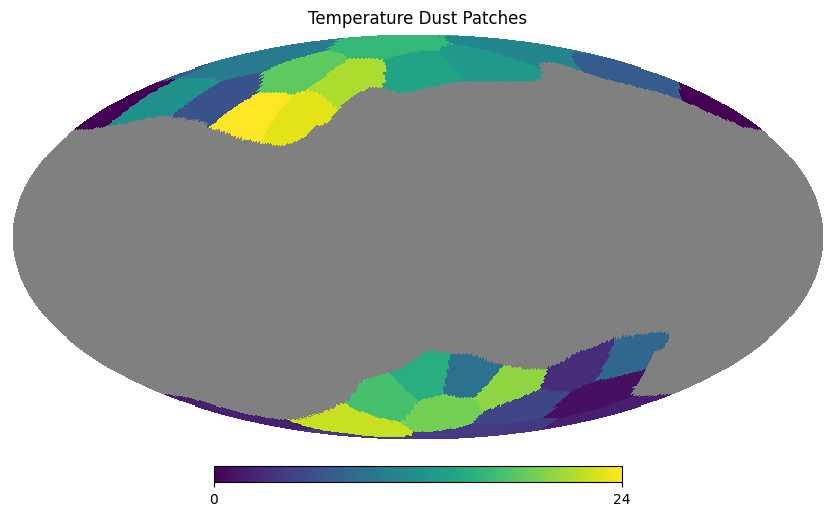

In [61]:
wrong_temp_dust_patches_count = 25


wrong_temp_dust_patch_indices = get_clusters(
    GAL020, wrong_temp_dust_patches_count, jax.random.PRNGKey(0)
)
hp.mollview(wrong_temp_dust_patch_indices, title='Temperature Dust Patches')

In [73]:
import jax_healpy as jhp
from furax.comp_sep import kmeans_sample

key = jax.random.PRNGKey(0)
n_regions = 30
npix = GAL020.size
nside = jhp.npix2nside(npix)
ipix = jnp.arange(npix)
ra, dec = jhp.pix2ang(nside, ipix, lonlat=True)
goodpix = GAL020 > 0
ra_dec = jnp.stack([ra[goodpix], dec[goodpix]], axis=-1)
km = kmeans_sample(key, ra_dec, n_regions, maxiter=100, tol=1.0e-5)

In [72]:
km.labels.max(), km.labels.min(), jnp.unique(km.labels).size

(Array(1, dtype=int32), Array(1, dtype=int32), 1)

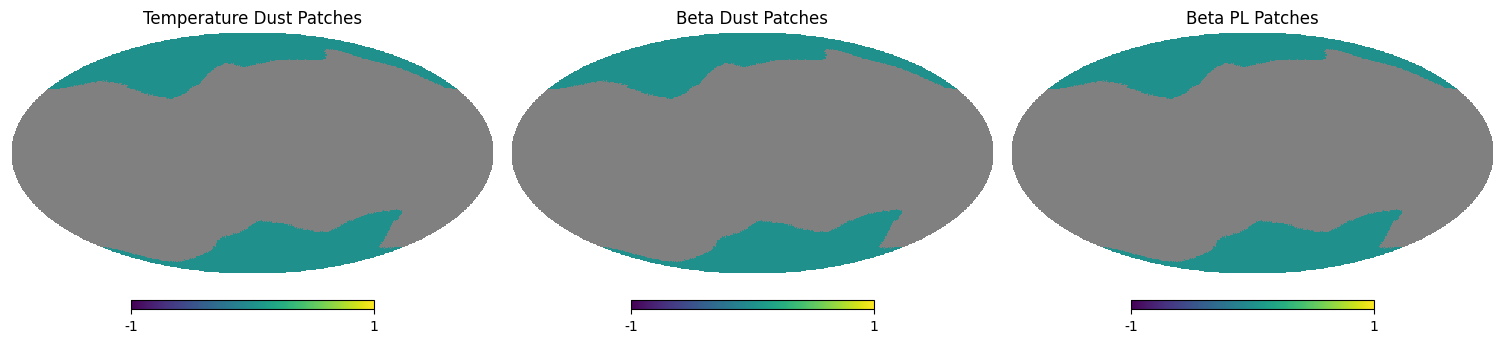

In [ ]:
wrong_temp_dust_patches_count = 100
wrong_beta_dust_patches_count = 200
wrong_beta_pl_patches_count = 300


wrong_temp_dust_patch_indices = get_clusters(
    GAL020, wrong_temp_dust_patches_count, jax.random.PRNGKey(0)
)
wrong_beta_dust_patch_indices = get_clusters(
    GAL020, wrong_beta_dust_patches_count, jax.random.PRNGKey(0)
)
wrong_beta_pl_patch_indices = get_clusters(
    GAL020, wrong_beta_pl_patches_count, jax.random.PRNGKey(0)
)

wrong_patch_params = {
    'temp_dust': jnp.linspace(10.0, 30.0, wrong_temp_dust_patches_count),
    'beta_dust': jnp.linspace(1.5, 2.5, wrong_beta_dust_patches_count),
    'beta_pl': jnp.linspace(-3.0, -2.0, wrong_beta_pl_patches_count),
}

wrong_patch_indices = {
    'temp_dust_patches': temp_dust_patch_indices,
    'beta_dust_patches': beta_dust_patch_indices,
    'beta_pl_patches': beta_pl_patch_indices,
}

# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(wrong_temp_dust_patch_indices, title='Temperature Dust Patches', sub=(1, 3, 1))
hp.mollview(wrong_beta_dust_patch_indices, title='Beta Dust Patches', sub=(1, 3, 2))
hp.mollview(wrong_beta_pl_patch_indices, title='Beta PL Patches', sub=(1, 3, 3))

# Display the plot
plt.show()


(indices,) = jnp.where(GAL020 == 1)

masked_sky = jax.tree.map(lambda full_map: get_cutout_from_mask(full_map, indices), sky)
masked_wrong_clusters = jax.tree.map(
    lambda full_map: get_cutout_from_mask(full_map, indices).astype(jnp.int32), wrong_patch_indices
)

In [ ]:
options = {'solver': lx.CG(rtol=1e-6, atol=1e-6, max_steps=100000), 'solver_throw': False}

with Config(**options):
    wrong_patch_final_params, wrong_patch_final_state = optimize(
        wrong_patch_params,
        spectral_cmb_variance,
        solver,
        max_iter=50,
        tol=1e-10,
        verbose=True,
        nu=nu,
        N=N,
        d=d,
        patch_indices=masked_wrong_clusters,
    )